In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import scipy
from scipy.interpolate import interp1d
from astropy import units as u
from astropy import constants as c
from astropy.table import Table
from astropy.modeling.models import Moffat1D

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rcParams['figure.figsize'] = 8, 6

In [4]:
import signal_to_noise as snr

# Input data

## Optics

Aperture sizes calculated from specs. RASA area includes an FLI Microline camera sized central obstruction. 

Canon focal length value from measured pixel scale, RASA from specs.

From http://www.canon.com/camera-museum/tech/report/2011/02/ know that the Canon lens is 16 elements in 12 groups, one element and group appears to be the filter. This implies 22 air-glass interfaces, excluding the filter, one of which is has Canon's proprietary nano-structured AR coating. Can get a ball park throughput estimate as a sanity check by assuming losses averaging 0.5% at each air-glass surface (appropriate for a high quality BBAR coating).



In [5]:
0.995**22

0.8955869907338783

This is consistent with the throughput lower limit of 85% published by the Dragonfly team. We'll use a wavelength independent figure of 0.9.

From http://www.celestron.com/browse-shop/astronomy/optical-tubes/rowe-ackermann-schmidt-astrograph we know that the RASA design includes 8 transmissive air-glass interfaces, excluding the filter, plus one mirror surface. Celestron publish plots for the throughput of their Schmidt corrector plates and mirror at http://www.celestron.com/university/astronomy/starbright-xlt-optical-coating-system. We can use these data plus an assumption of 0.5% losses at the 6 remaining air-glass interfaces to estimate overall throughput as a function of wavelength.

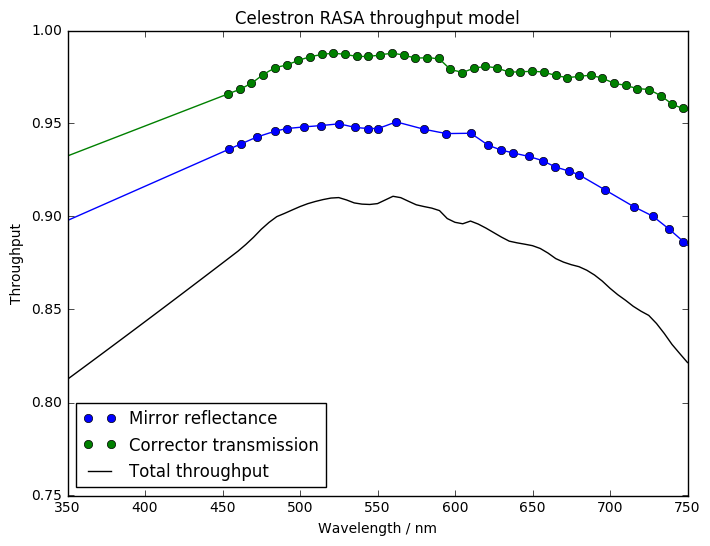

In [6]:
m = Table.read('resources/mirror.csv')
c = Table.read('resources/corrector.csv')

waves = np.arange(350,751,5)

mi = interp1d(m['Wavelength'], m['Throughput'], kind='linear', fill_value='extrapolate')
ci = interp1d(c['Wavelength'], c['Throughput'], kind='linear', fill_value='extrapolate')

tau = mi(waves) * ci(waves) * 0.995**6

rasa_tau = Table((waves, tau), names=('Wavelength', 'Throughput'))
rasa_tau['Wavelength'].unit = u.nm
rasa_tau['Throughput'].unit = u.dimensionless_unscaled
rasa_tau.write('resources/rasa_tau.csv')

plt.plot(m['Wavelength'], m['Throughput'], 'bo', label='Mirror reflectance')
plt.plot(waves, mi(waves), 'b-')
plt.plot(c['Wavelength'], c['Throughput'], 'go', label='Corrector transmission')
plt.plot(waves, ci(waves), 'g-')
plt.plot(rasa_tau['Wavelength'], rasa_tau['Throughput'], 'k-', label='Total throughput')
plt.xlabel('Wavelength / nm')
plt.ylabel('Throughput')
plt.title('Celestron RASA throughput model')
plt.ylim(0.75,1)
plt.legend(loc='best')

In [7]:
canon = snr.Optic(aperture = 139.642857143 * u.mm, \
                  focal_length = 391.0 * u.mm, \
                  throughput_filename='resources/canon_throughput.csv')

rasa= snr.Optic(aperture = 279.0 * u.mm, \
                focal_length = 620.0 * u.mm, \
                throughput_filename='resources/rasa_tau.csv', \
                central_obstruction = 129.0 * u.mm)

## Cameras

Most specifications here come from the corresponding Finger Lakes Instrumentation (FLI) [Microline camera specifications](http://www.flicamera.com/microline/index.html), with the exception of the KAF-8300M which uses the specifications for the [SBIG STF-8300M](https://www.sbig.com/products/cameras/stf-series/stf/stf-8300m/).  The read noise values used are for the lowest readout speed offered by FLI, which varies from camera to camera, and the dark current values are specified at various temperatures and are in some cases upper limits and in others 'typical' values.  Cost estimates are based on the retail prices at OptCorp in USD for a camera with a Grade 1 sensor.
sb

(0, 0.5)

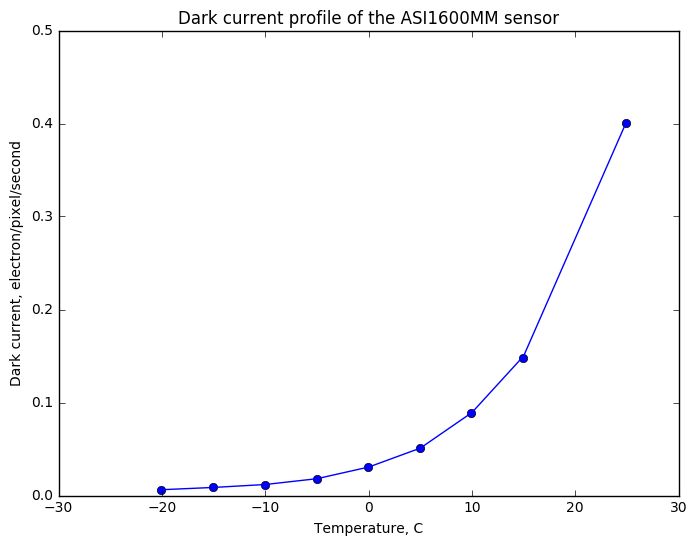

In [8]:
#Plotting the dark current versus temperature graphs for the ZWO ASI1600MM sensor
td = Table.read('resources/DarkcurrentZWO.csv')
temp = np.arange(-20, 30, 5)
tdi = interp1d(td['Temperature'], td['Dark current'], kind='linear', fill_value='extrapolate')
darkcur = tdi(temp)
plt.plot(td['Temperature'], td['Dark current'], 'bo')
plt.plot(temp, darkcur, 'b')
plt.xlabel('Temperature, C')
plt.ylabel('Dark current, electron/pixel/second')
plt.title('Dark current profile of the ASI1600MM sensor')
plt.ylim(0,0.5)

In [9]:
sbig = snr.Camera(pixel_size = 5.4 * u.micron / u.pixel, \
                  resolution = (3326, 2504) * u.pixel, \
                  read_noise = 9.3  * u.electron / u.pixel, \
                  dark_current = 0.04 * u.electron / (u.second * u.pixel), \
                  QE_filename = "resources/ML8300M_QE.csv") # Dark current 'average' at -10C

fli = snr.Camera(pixel_size = 6.0 * u.micron / u.pixel, \
                 resolution = (8176, 6132) * u.pixel, \
                 read_noise = 12.0  * u.electron / u.pixel, \
                 dark_current = 0.015 * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ML50100_QE.csv") #Dark current at -25C

zwo = snr.Camera(pixel_size = 3.8 * u.micron / u.pixel, \
                 resolution = (4656, 3520) * u.pixel, \
                 read_noise = 2.5 * u.electron / u.pixel, \
                 dark_current = darkcur[1] * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ZWO_QE.csv") #the value of the dark current has been approximated

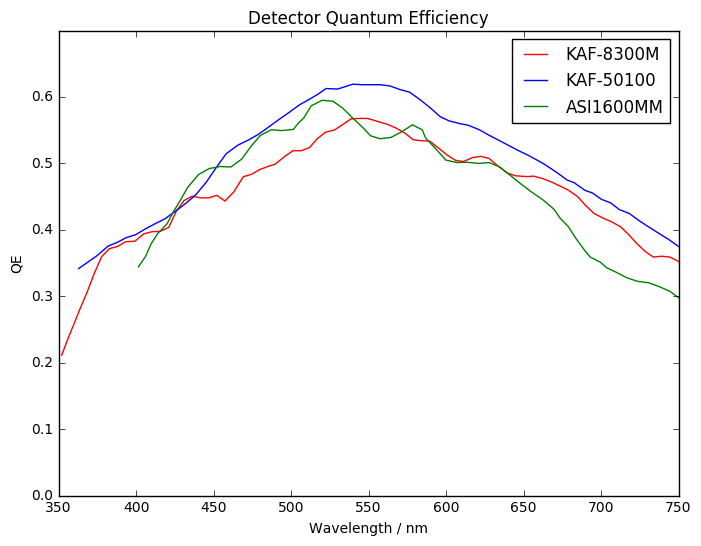

In [10]:
plt.plot(sbig.wavelengths, sbig.QE, 'r-', label='KAF-8300M')
plt.plot(fli.wavelengths, fli.QE, 'b-', label='KAF-50100')
plt.plot(zwo.wavelengths, zwo.QE, 'g-', label='ASI1600MM')
plt.xlim(350,750)
plt.ylim(0,0.7)
plt.xlabel('Wavelength / nm')
plt.ylabel('QE')
plt.legend(loc='best')
plt.title('Detector Quantum Efficiency')

## Filters

Transmission curves for Astrodon's filters are on the website. The data are assumed to be for collimated illumination, however, so may not represent the effective transmission when used with f/2.8 or f/2.2 optics. DECam g' & r' filter transmission are used as a comparison. As a modern f/2.9 instrument DECam is probably a good example of the throughout that can be achieved with fast beams. Scaling the Astrodon filter transmission down by a factor of 0.92 approximately matches the in g' and r' band average transmissions. For a conservative estimate we'll do just that. The narrowband filters are likely to be effected more by the fast beam, Astrodon's narrowband FAQ (http://astrodon.com/uploads/3/4/9/0/34905502/astrodonnarrowbandfaq.pdf) suggests 'not significant' loss at f/3 for the 5 nm filters and 15-20% loss at f/3 for the 3 nm filters. The effect of fast beams on narrowband filters is actually quite complicated (broadening the filter profile and shifting it bluewards as well as lower peak transmission) but we'll just apply a transmission scaling for now.

Sky surface brightness, g' & r' band are dark time guesstimates based on B, V, R values for Siding Spring from http://www.mso.anu.edu.au/pfrancis/reference/reference/node4.html

The H-alpha sky brightness is a guess at the average for bright time, taken as 1 magnitude above the dark sky r' band value. The full Moon sky at Siding Spring is 1.9 magnitudes brighter than the dark sky in R so given the opposition effect and an assumption of clever target selection this seems reasonable.

In [11]:
fudge_factor = 0.92

g_Astrodon = snr.Filter('resources/astrodon_g.csv', sky_mu = 22.5)
r_Astrodon = snr.Filter('resources/astrodon_r.csv', sky_mu = 21.5)
Ha_3nm = snr.Filter('resources/astrodon_ha_3nm.csv', sky_mu = 20.5)
Ha_5nm = snr.Filter('resources/astrodon_ha_5nm.csv', sky_mu = 20.5)

In [12]:
g_Astrodon.transmission *= fudge_factor
r_Astrodon.transmission *= fudge_factor
Ha_3nm.transmission *= 0.8
Ha_5nm.transmission *= fudge_factor

In [13]:
g_DECam = snr.Filter('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.g', sky_mu = 22.5)
r_DECam = snr.Filter('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.r', sky_mu = 21.5)

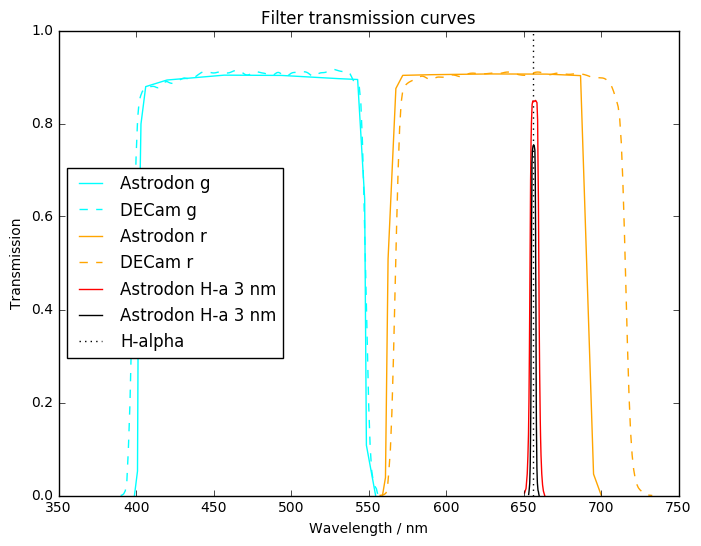

In [14]:
plt.plot(g_Astrodon.wavelengths, g_Astrodon.transmission, '-', color='cyan', label='Astrodon g')
plt.plot(g_DECam.wavelengths, g_DECam.transmission, '--', color='cyan', label='DECam g')
plt.plot(r_Astrodon.wavelengths, r_Astrodon.transmission, '-', color='orange', label='Astrodon r')
plt.plot(r_DECam.wavelengths, r_DECam.transmission, '--', color='orange', label='DECam r')
plt.plot(Ha_5nm.wavelengths, Ha_5nm.transmission, '-', color='red', label='Astrodon H-a 3 nm')
plt.plot(Ha_3nm.wavelengths, Ha_3nm.transmission, '-', color='black', label='Astrodon H-a 3 nm')
plt.vlines(656.28, 0, 1, color='black', linestyles=('dotted',), label='H-alpha')
plt.xlim(350,750)
#plt.xlim(640,670)
plt.ylim(0,1)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.legend(loc='best')
plt.title('Filter transmission curves')

## Imagers

Combine optics, filters and cameras and check for consistency with published Dragonfly calculations.

In [15]:
#let's first create objects in the Moffat_PSF class
canon_sbig_psf = snr.Moffat_PSF(FWHM=2 * u.arcsecond, alpha=2.5)
canon_fli_psf = snr.Moffat_PSF(FWHM=2 * u.arcsecond, alpha=2.5)
canon_zwo_psf = snr.Moffat_PSF(FWHM=2 * u.arcsecond, alpha=2.5)
rasa_fli_psf = snr.Moffat_PSF(FWHM=2 * u.arcsecond, alpha=2.5)

In [16]:
#creating objects in the Imager class
canon_sbig_g = snr.Imager(canon, sbig, g_Astrodon, canon_sbig_psf)
canon_sbig_r = snr.Imager(canon, sbig, r_Astrodon, canon_sbig_psf)
canon_sbig_Ha5 = snr.Imager(canon, sbig, Ha_5nm, canon_sbig_psf)
canon_sbig_Ha3 = snr.Imager(canon, sbig, Ha_3nm, canon_sbig_psf)
canon_fli_g = snr.Imager(canon, fli, g_Astrodon, canon_fli_psf)
canon_fli_r = snr.Imager(canon, fli, r_Astrodon, canon_fli_psf)
canon_fli_Ha5 = snr.Imager(canon, fli, Ha_5nm, canon_fli_psf)
canon_fli_Ha3 = snr.Imager(canon, fli, Ha_3nm, canon_fli_psf)
canon_zwo_g = snr.Imager(canon, zwo, g_Astrodon, canon_zwo_psf)
canon_zwo_r = snr.Imager(canon, zwo, r_Astrodon, canon_zwo_psf)
canon_zwo_Ha5 = snr.Imager(canon, zwo, Ha_5nm, canon_zwo_psf)
canon_zwo_Ha3 = snr.Imager(canon, zwo, Ha_3nm, canon_zwo_psf)
rasa_fli_g = snr.Imager(rasa, fli, g_Astrodon, rasa_fli_psf)
rasa_fli_r = snr.Imager(rasa, fli, r_Astrodon, rasa_fli_psf)
rasa_fli_Ha5 = snr.Imager(rasa, fli, Ha_5nm, rasa_fli_psf)

In [17]:
canon_zwo_g.pixel_scale

<Quantity 2.0046196003554124 arcsec / pix>

In [18]:
(canon_zwo_g.pixel_scale*canon_zwo_g.camera.resolution).to(u.degree)

<Quantity [ 2.59264135, 1.9600725 ] deg>

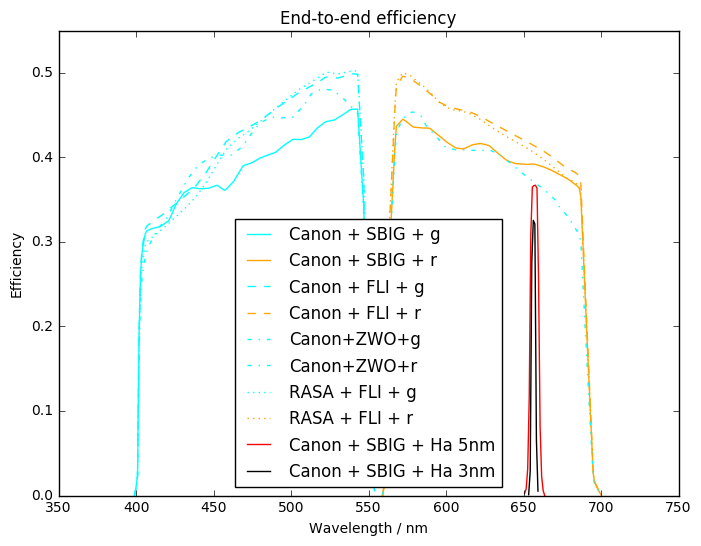

In [19]:
plt.plot(canon_sbig_g.wavelengths, canon_sbig_g.efficiencies, color='cyan', label='Canon + SBIG + g')
plt.plot(canon_sbig_r.wavelengths, canon_sbig_r.efficiencies, color='orange', label='Canon + SBIG + r')
plt.plot(canon_fli_g.wavelengths, canon_fli_g.efficiencies, '--', color='cyan', label='Canon + FLI + g')
plt.plot(canon_fli_r.wavelengths, canon_fli_r.efficiencies, '--', color='orange', label='Canon + FLI + r')
plt.plot(canon_zwo_g.wavelengths, canon_zwo_g.efficiencies, '-.', color='cyan', label='Canon+ZWO+g')
plt.plot(canon_zwo_r.wavelengths, canon_zwo_r.efficiencies, '-.', color='cyan', label='Canon+ZWO+r')
plt.plot(rasa_fli_g.wavelengths, rasa_fli_g.efficiencies, ':', color='cyan', label='RASA + FLI + g')
plt.plot(rasa_fli_r.wavelengths, rasa_fli_r.efficiencies, ':', color='orange', label='RASA + FLI + r')
plt.plot(canon_sbig_Ha5.wavelengths, canon_sbig_Ha5.efficiencies, color='red', label='Canon + SBIG + Ha 5nm')
plt.plot(canon_sbig_Ha3.wavelengths, canon_sbig_Ha3.efficiencies, color='black', label='Canon + SBIG + Ha 3nm')
plt.xlim(350,750)
plt.ylim(0,0.55)
plt.legend(loc='best')
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency')
plt.title('End-to-end efficiency')

In [20]:
canon_sbig_g.efficiency

<Quantity 0.36669591617603997 electron / ph>

In [21]:
canon_sbig_r.efficiency

<Quantity 0.3692710380230374 electron / ph>

The Dragonfly team reported a measured end-to-end efficiency (after several months without cleaning) of 34% in g' and 35% in r', i.e. within 1% of these calculated values. Estimates of filter transmission and optics throughput seem pretty good.

In [22]:
canon_sbig_g.mean_wave

<Quantity 479.5147894099945 nm>

In [23]:
canon_sbig_r.mean_wave

<Quantity 625.0704238949774 nm>

The Dragonfly team calculated mean wavelengths of 485.7 nm and 627.3 nm for the g' and r' bands based on their assumed filter transmission and detector QE curves. No serious discrepancy here.

In [24]:
canon_sbig_g.gamma0

<Quantity 1773419212.2920463 ph / (pix s)>

In [25]:
canon_sbig_r.gamma0

<Quantity 1277245076.044416 ph / (pix s)>

Using somewhat different definitions of bandwidth and effective wavelength the Dragonfly team calculated these factors as $1.79\times 10^9$ and $1.16 \times 10^9$ respectively, again no real discrepancy.

In [26]:
canon_sbig_g.ABmag_to_rate(0)

<Quantity 100245479.5302832 electron / s>

In [27]:
canon_sbig_g.SB_to_rate(0)

<Quantity 813484100.0694036 electron / (pix s)>

In [28]:
canon_sbig_g.SB_snr(26.0, total_exp_time=13000)

Rounding up total exposure time to next integer multiple of sub-exposure time: 13200.0 s


<Quantity 3.433765553856555>

In [29]:
canon_sbig_g.SB_etc(22, snr_target=5.3, sub_exp_time=60)

(<Quantity 120.0 s>, 2)

In [30]:
canon_sbig_g.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=300*u.second, N=5)

<Quantity 29.33121522653336 mag(AB)>

In [31]:
canon_sbig_g.SB_limit(total_exp_time=28 * u.hour, snr_target=5.0, sub_exp_time=300*u.second, N=5, binning=3600)

<Quantity 32.029824333535174 mag(AB)>

In [32]:
canon_sbig_r.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=300*u.second, N=5)

<Quantity 28.70939658023189 mag(AB)>

In [33]:
canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=1200*u.second, N=10)

<Quantity 26.63523618636537 mag(AB)>

In [34]:
canon_sbig_Ha5.ABmag_to_flux(canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=1200*u.second, N=10))

<Quantity 1.2267974426077877e-21 W / m2>

In [35]:
canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=5.0, sub_exp_time=1200*u.second, N=10, binning=3600)

<Quantity 29.33416999548526 mag(AB)>

In [36]:
canon_sbig_Ha5.pixel_scale

<Quantity 2.8486699583997965 arcsec / pix>

In [37]:
math.log10(canon_sbig_Ha5.pixel_area * 5.1042415945087409 * u.pixel / (u.arcsecond ** 2)) * 2.5 + 25.291131

29.33416973369891

In [38]:
canon_sbig_Ha5.pointsource_limit(total_exp_time=28 * u.hour, snr_target=5.0, sub_exp_time=1200*u.second, N=10, binning=3600)

<Quantity 26.17609497742222 mag(AB)>

In [39]:
canon_sbig_Ha5.pivot_wave

<Quantity 656.4926763738649 nm>

In [40]:
10**-0.4

0.3981071705534972

## Plots

Now, we calculate the surface brightness limits, point source brightness limits, and saturation limits as a function of sub-exposure time for different imager combinations, and produce corresponding plots.

In [41]:
def calculate_limits(imager, snr_type, snr_value, total_exp_time, sub_exp_time, number=1, surface_calc=True):
    #surface_calc gives us the flexibility of switching between point source brightness limit and surface brightness limit calculations
    if not isinstance(imager, snr.Imager):
        raise ValueError("imager must be an instance of the Imager class")
    limit_all= u.Quantity(imager.SB_limit(total_exp_time, snr_value, snr_type, sub_exp_time, N=number) if surface_calc else imager.pointsource_limit(total_exp_time, snr_value, sub_exp_time, N=number))
    limit_noread= u.Quantity(imager.SB_limit(total_exp_time, snr_value, snr_type, sub_exp_time, N=number, enable_read_noise=False) if surface_calc else imager.pointsource_limit(total_exp_time, snr_value, sub_exp_time, N=number, enable_read_noise=False))
    limit_skyonly= u.Quantity(imager.SB_limit(total_exp_time, snr_value, snr_type, sub_exp_time, N=number, enable_read_noise=False, enable_dark_noise=False) \
                    if surface_calc else imager.pointsource_limit(total_exp_time, snr_value, sub_exp_time, N=number, enable_read_noise=False, enable_dark_noise=False))
    return (sub_exp_time, limit_all, limit_noread, limit_skyonly)

In [42]:
def sensitivity_plot(times, data1, data2, data3, plot_number, colour, name, num_rows=2):
    plt.subplot(num_rows,1,plot_number)
    plt.semilogx(times, data1, '{}-'.format(colour), label='{} all noise sources'.format(name))
    plt.semilogx(times, data2, '{}--'.format(colour), label='{} no read noise'.format(name))
    plt.semilogx(times, data3, '{}:'.format(colour), label='{} sky noise only'.format(name))

The first set of plots have limiting surface brightness on the y-axis and varying sub-exposure time on the x-axis. This is done for various imager combinations. The solid lines represent the curves with all noise sources included, the broken lines exclude the read noise, and the dotted lines take into account the sky noise only. The signal-to-noise ratio is fixed at 3-$\sigma$ per pixel. 

In [43]:
exptime=np.arange(10,1001,10) * u.second #sub-exposure time range for g and r bands 
ext_exptime = np.arange(10,2001,10) * u.second #sub-exposure time range for Ha-5nm band
ts, sg, sgr, sgi = calculate_limits(canon_sbig_g, 'per pixel', 3.0, exptime, exptime)
ts, sr, srr, sri = calculate_limits(canon_sbig_r, 'per pixel', 3.0, exptime, exptime)
ts, sg1, sgr1, sgi1 = calculate_limits(canon_fli_g,'per pixel', 3.0, exptime, exptime)
ts, sr1, srr1, sri1 = calculate_limits(canon_fli_r,'per pixel', 3.0, exptime, exptime)
ts, sg2, sgr2, sgi2 = calculate_limits(rasa_fli_g,'per pixel', 3.0, exptime, exptime)
ts, sr2, srr2, sri2 = calculate_limits(rasa_fli_r,'per pixel', 3.0, exptime, exptime)
ts, sg3, sgr3, sgi3 = calculate_limits(canon_zwo_g, 'per pixel', 3.0, exptime, exptime)
ts, sr3, srr3, sri3 = calculate_limits(canon_zwo_r, 'per pixel', 3.0, exptime, exptime)

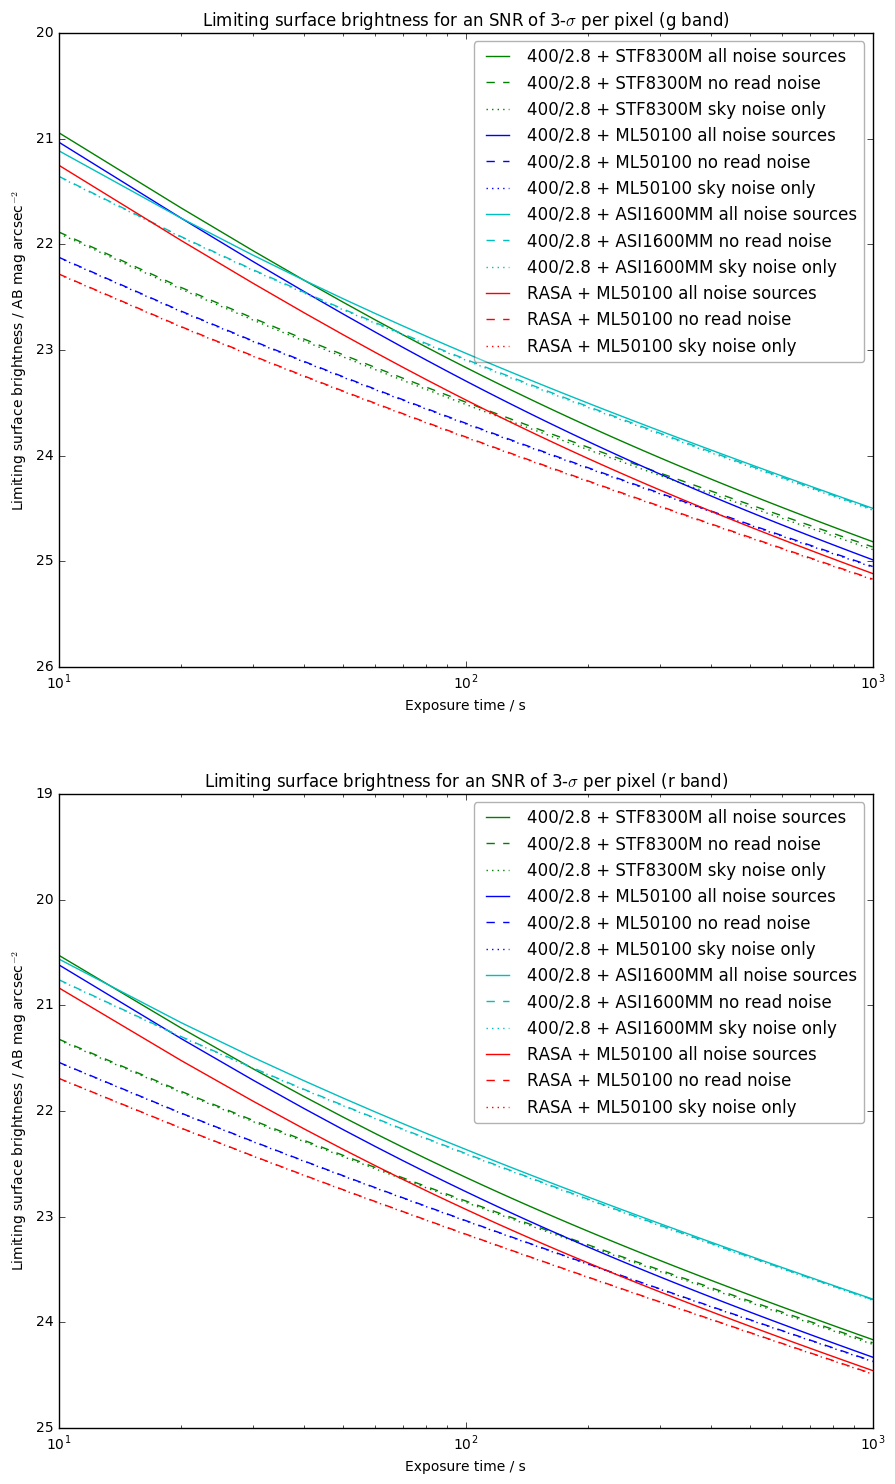

In [44]:
sensitivity_plot(ts, sg, sgr, sgi, 1, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, sr, srr, sri, 2, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, sg1, sgr1, sgi1, 1, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, sr1, srr1, sri1, 2, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, sg3, sgr3, sgi3, 1, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, sr3, srr3, sri3, 2, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, sg2, sgr2, sgi2, 1, 'r', 'RASA + ML50100')
sensitivity_plot(ts, sr2, srr2, sri2, 2, 'r', 'RASA + ML50100')
plt.subplot(2,1,1)
plt.ylim(26,20)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 3-$\sigma$ per pixel (g band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(2,1,2)
plt.ylim(25,19)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 3-$\sigma$ per pixel (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,18)
plt.savefig('sensitivityplot.png')

Both the plots above show similar patterns. For one, RASA + ML50100 seems to be the best combination in terms of the highest limiting surface brightness limit. The sky noise only and the no read noise plots seem to be coincident pretty much for every value of exposure time, highlighting the negligible role that dark current plays. While 400/2.8 + ASI1600MM seems to be 'good' for very low exposure times, it is seen to be the worst combination for high exposure times. 

We don't have a full picture yet, as calculating signal-to-noise in $\sigma$ per pixel is quite misleading, as different sensors have different pixel sizes. Therefore a second set of plots have been produced using a signal-to-noise ratio of 1.0 $\sigma$ per arcseconds squared rather than 3.0 $\sigma$ per pixel, and have been provided below.

In [45]:
ts, lg, lgr, lgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0, exptime, exptime)
ts, lr, lrr, lri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0, exptime, exptime)
ts, lg1, lgr1, lgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0, exptime, exptime)
ts, lr1, lrr1, lri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0, exptime, exptime)
ts, lg2, lgr2, lgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0, exptime, exptime)
ts, lr2, lrr2, lri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0, exptime, exptime)
ts, lg3, lgr3, lgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0, exptime, exptime)
ts, lr3, lrr3, lri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0, exptime, exptime)

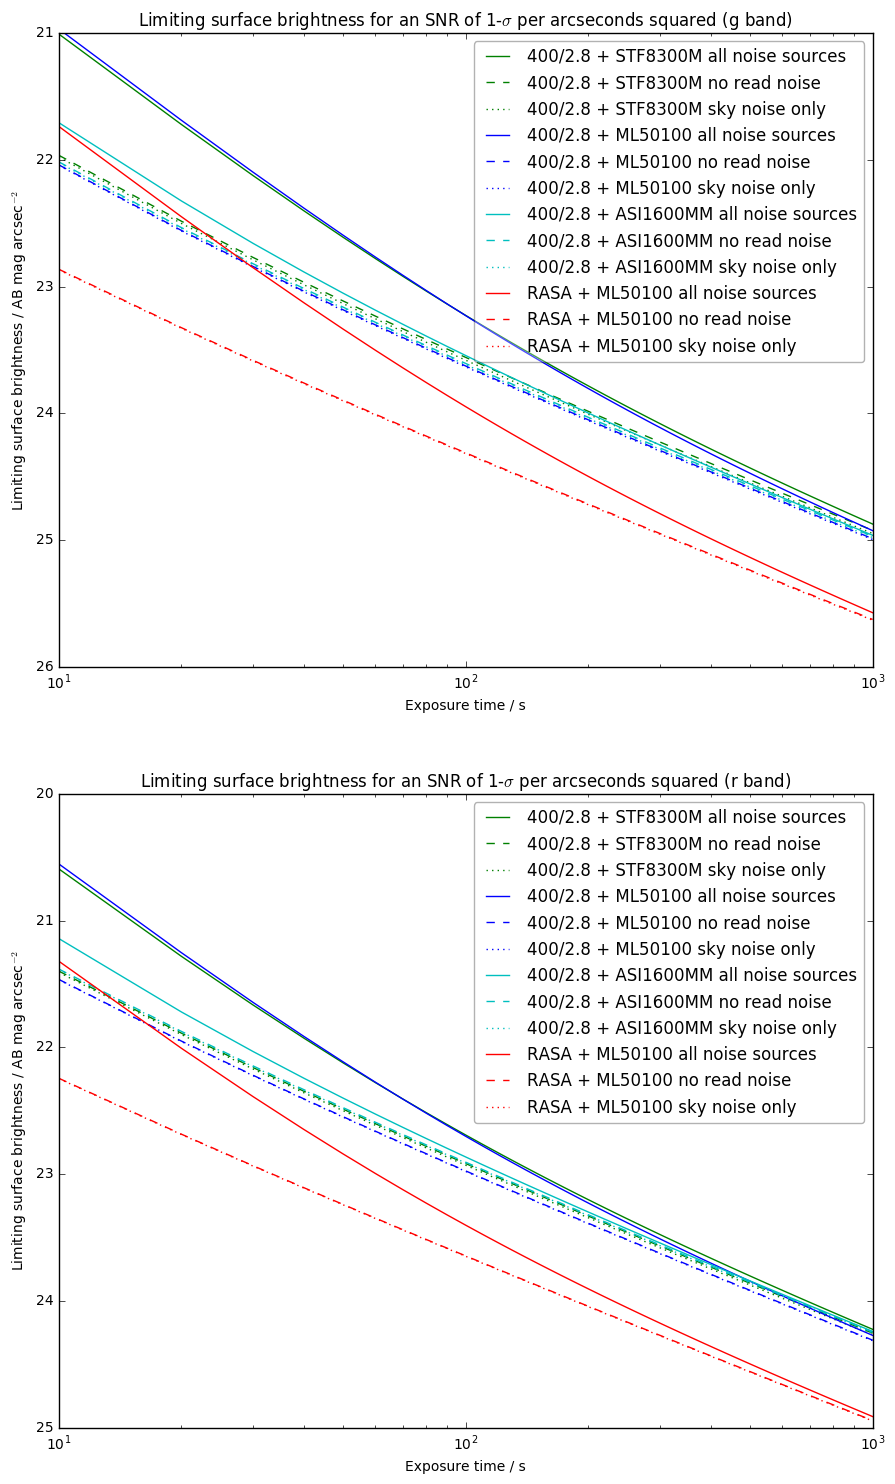

In [46]:
sensitivity_plot(ts, lg, lgr, lgi, 1, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, lr, lrr, lri, 2, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, lg1, lgr1, lgi1, 1, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, lr1, lrr1, lri1, 2, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, lg3, lgr3, lgi3, 1, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, lr3, lrr3, lri3, 2, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, lg2, lgr2, lgi2, 1, 'r', 'RASA + ML50100')
sensitivity_plot(ts, lr2, lrr2, lri2, 2, 'r', 'RASA + ML50100')
plt.subplot(2,1,1)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (g band)')
plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.subplot(2,1,2)
plt.ylim(25,20)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,18)
plt.savefig('sensitivityplot1.png')

While RASA+ML50100 still seems to be the best option in regards to seeing fainter objects, 400/2.8 + ASI1600MM is no longer the worst option. In fact, it is the second best option; while it is seen to be not very far from RASA+ML50100 for low exposure times, the trend deviates and merges with the other two 400/2.8 imager combinations for higher exposure times. 

The plots are still a bit misleading, as we haven't taken into account the fact that we are using different numbers of lens -- 5 Canon and 2 RASA. The forthcoming plots take this into account. 

In [47]:
ts, pg, pgr, pgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0, exptime, exptime, 5)
ts, pr, prr, pri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0, exptime, exptime, 5)
tsh, ph, phr, phi = calculate_limits(canon_sbig_Ha5,'per arcseconds squared', 1.0, ext_exptime, ext_exptime, 5)
ts, pg1, pgr1, pgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0, exptime, exptime, 5)
ts, pr1, prr1, pri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0, exptime, exptime, 5)
tsh, ph1, phr1, phi1 = calculate_limits(canon_fli_Ha5,'per arcseconds squared', 1.0, ext_exptime, ext_exptime, 5)
ts, pg2, pgr2, pgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0, exptime, exptime, 2)
ts, pr2, prr2, pri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0, exptime, exptime, 2)
tsh, ph2, phr2, phi2 = calculate_limits(rasa_fli_Ha5,'per arcseconds squared', 1.0, ext_exptime, ext_exptime, 2)
ts, pg3, pgr3, pgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0, exptime, exptime, 5)
ts, pr3, prr3, pri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0, exptime, exptime, 5)
tsh, ph3, phr3, phi3 = calculate_limits(canon_zwo_Ha5,'per arcseconds squared', 1.0, ext_exptime, ext_exptime, 5)

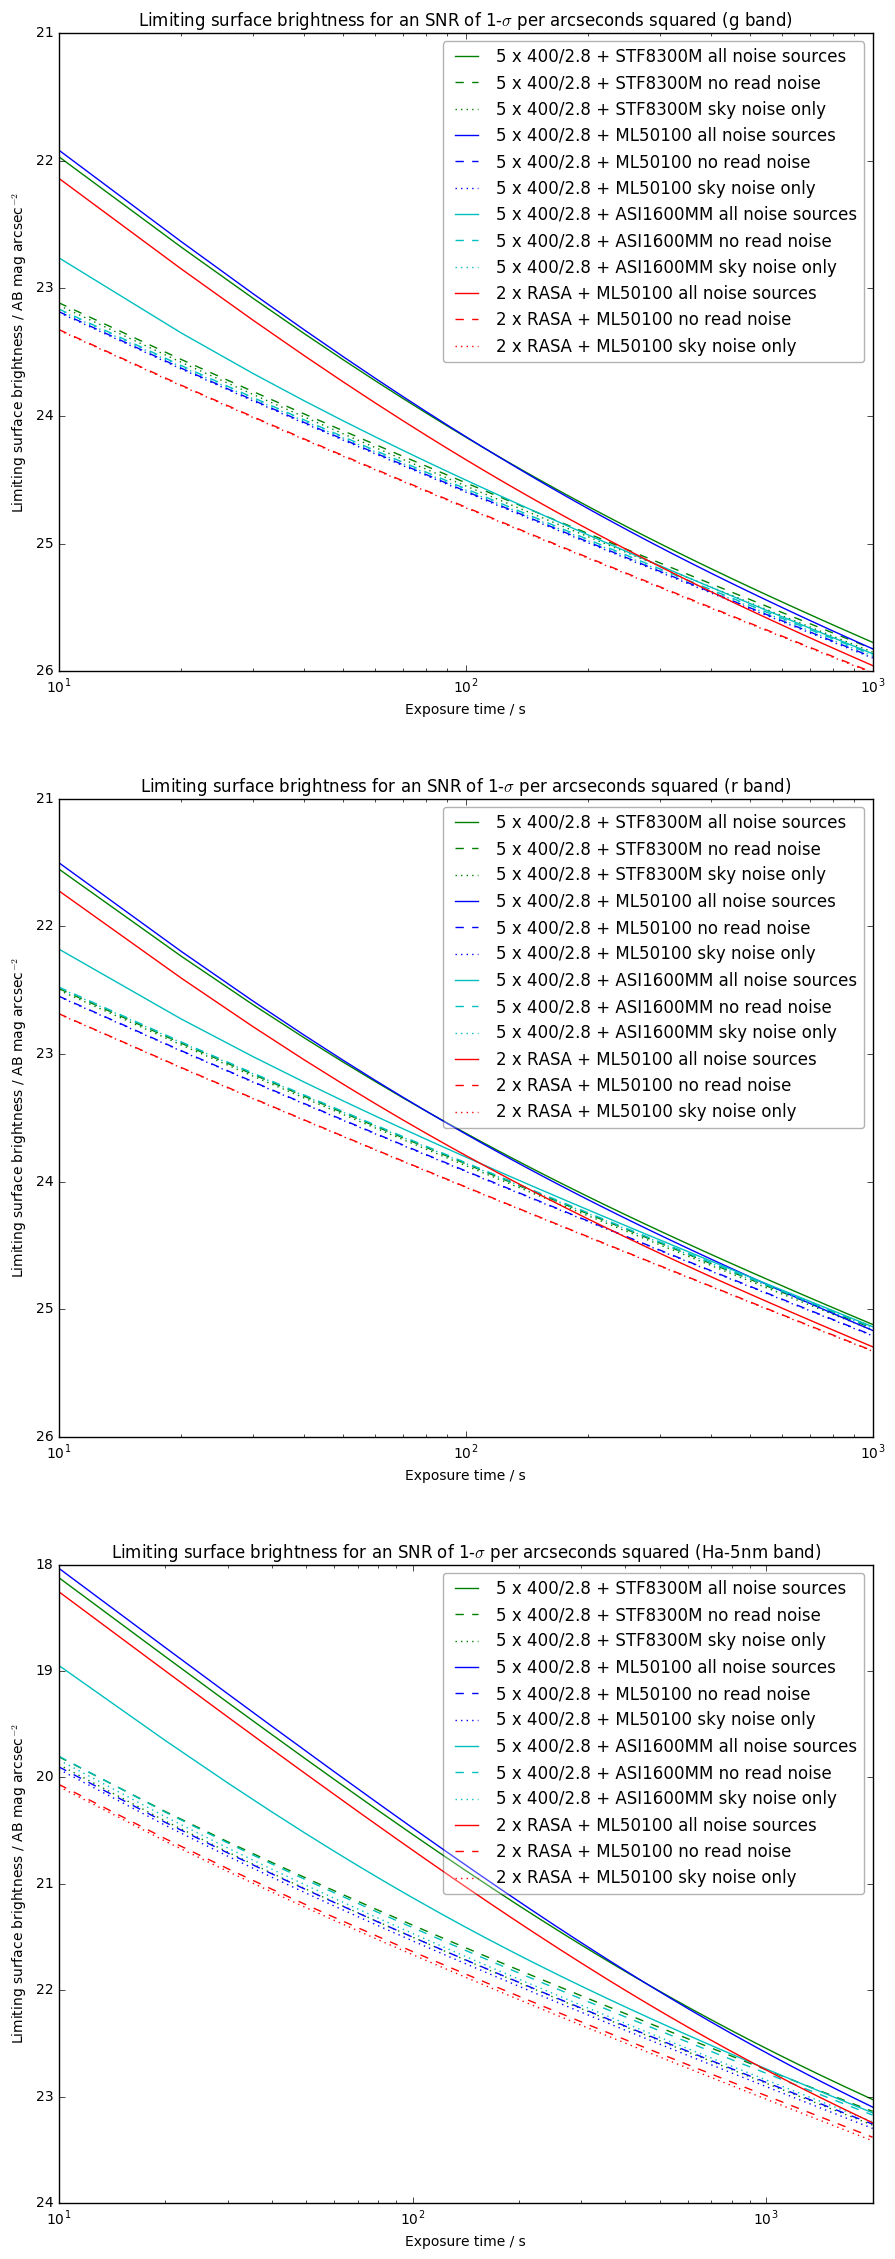

In [48]:
sensitivity_plot(ts, pg, pgr, pgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3) 
sensitivity_plot(ts, pr, prr, pri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, ph, phr, phi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, pg1, pgr1, pgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, pr1, prr1, pri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, ph1, phr1, phi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, pg3, pgr3, pgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, pr3, prr3, pri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, ph3, phr3, phi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, pg2, pgr2, pgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, pr2, prr2, pri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, ph2, phr2, phi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (g band)')
plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(24,18)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot2.png')

First thing to notice is that there is an extra plot now, for Hydrogen alpha 5 nm band. Now, comparing the 4 different imager combinations in regards to the limiting surface brightness, a slightly different trend has appeared. The RASA + ML50100 and 400/2.8 + ASI1600MM have sort of swapped positions. For relatively low exposure times (say < 100 seconds), 400/2.8 + ASI1600MM seems to be the best option, while RASA + ML50100 takes over at higher exposure times. 

All of the calculations so far have been for single exposure, i.e. total exposure time = sub exposure time. However, we want to capture the image for long hours, and therefore single exposure wouldn't be enough. We set a value of 28 hours for the total exposure time, while varying the sub exposure time in the same way as before. The corresponding plots have been presented below.

In [49]:
ts, qg, qgr, qgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
ts, qr, qrr, qri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
tsh, qh, qhr, qhi = calculate_limits(canon_sbig_Ha5, 'per arcseconds squared', 1.0, 28 * u.hour, ext_exptime, 5)
ts, qg1, qgr1, qgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
ts, qr1, qrr1, qri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
tsh, qh1, qhr1, qhi1 = calculate_limits(canon_fli_Ha5,'per arcseconds squared', 1.0, 28 * u.hour, ext_exptime, 5)
ts, qg2, qgr2, qgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0, 28 * u.hour, exptime, 2)
ts, qr2, qrr2, qri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0, 28 * u.hour, exptime, 2)
tsh, qh2, qhr2, qhi2 = calculate_limits(rasa_fli_Ha5,'per arcseconds squared', 1.0, 28 * u.hour, ext_exptime, 2)
ts, qg3, qgr3, qgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
ts, qr3, qrr3, qri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0, 28 * u.hour, exptime, 5)
tsh, qh3, qhr3, qhi3 = calculate_limits(canon_zwo_Ha5, 'per arcseconds squared', 1.0, 28 * u.hour, ext_exptime, 5)

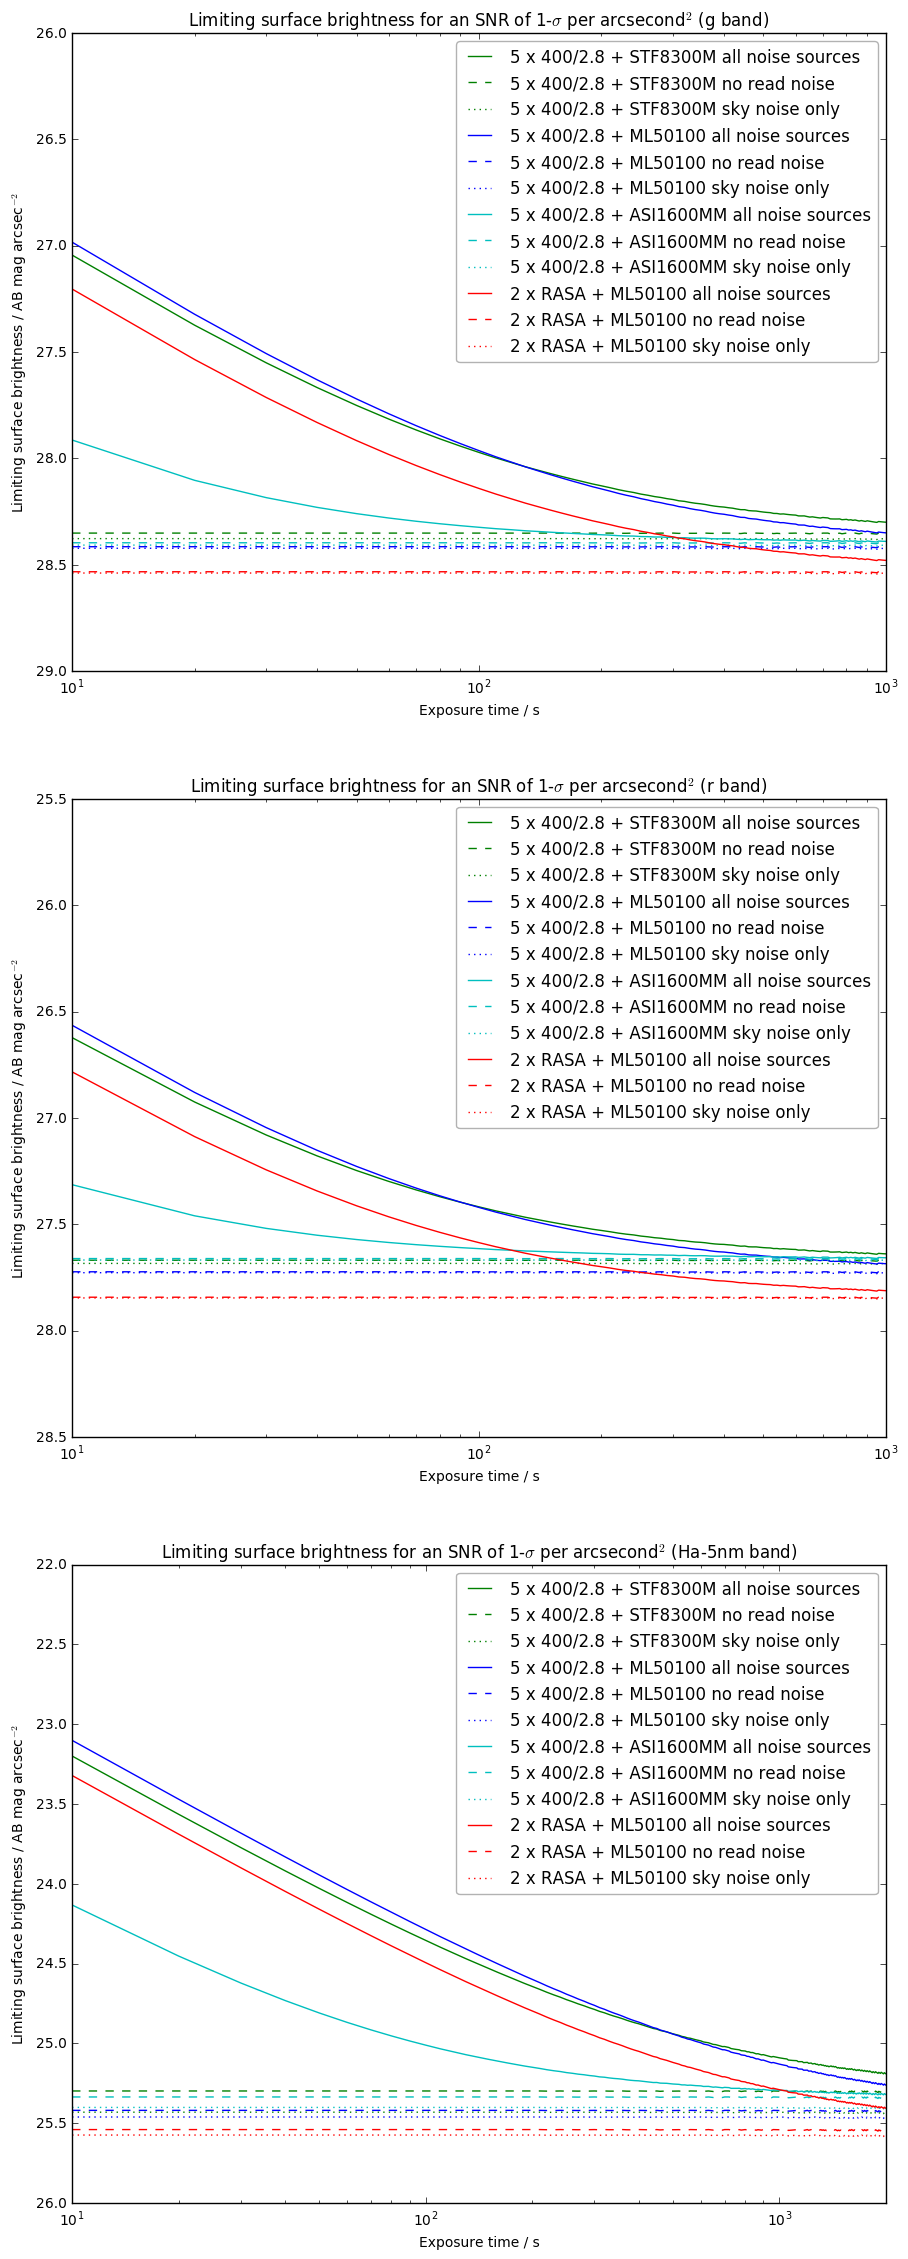

In [50]:
sensitivity_plot(ts, qg, qgr, qgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qr, qrr, qri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, qh, qhr, qhi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qg1, qgr1, qgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qr1, qrr1, qri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, qh1, qhr1, qhi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qg3, qgr3, qgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qr3, qrr3, qri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, qh3, qhr3, qhi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qg2, qgr2, qgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, qr2, qrr2, qri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, qh2, qhr2, qhi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(29,26)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (g band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(28.5,25.5)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(26,22)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot3.png')

The trend from the previous plots have prevailed. 400/2.8 + ASI1600MM combination seems to be the best option for low exposure times while RASA + M50100 is still the best combination for higher exposure times. 

Now, we look at point source limiting magntiudes instead of limiting surface brightness, so basically we do the same analysis but for point objects. The first set of plots present limiting point source brightness versus exposure time for a single exposure for the four different imager combinations, taking into the account the different numbers of lens used.  

One of the things to note in the following calculations is that we resort back to 'per pixel' calculation, as in the pointsource_limit function in the python code, we take the binning to equal to n_pix, which gives us the signal to noise ratio for the entire point source image. 

In [51]:
#Point source limiting brightness calculations for single lens single exposure
ts, psg, psgr, psgi = calculate_limits(canon_sbig_g, 'per pixel', 3.0, exptime, exptime, 5, False)
ts, psr, psrr, psri = calculate_limits(canon_sbig_r, 'per pixel', 3.0, exptime, exptime, 5, False)
tsh, psh, pshr, pshi = calculate_limits(canon_sbig_Ha5,'per pixel', 3.0, ext_exptime, ext_exptime, 5, False)
ts, psg1, psgr1, psgi1 = calculate_limits(canon_fli_g,'per pixel', 3.0, exptime, exptime, 5, False)
ts, psr1, psrr1, psri1 = calculate_limits(canon_fli_r,'per pixel', 3.0, exptime, exptime, 5, False)
tsh, psh1, pshr1, pshi1 = calculate_limits(canon_fli_Ha5,'per pixel', 3.0, ext_exptime, ext_exptime, 5, False)
ts, psg2, psgr2, psgi2 = calculate_limits(rasa_fli_g,'per pixel', 3.0, exptime, exptime, 2, False)
ts, psr2, psrr2, psri2 = calculate_limits(rasa_fli_r,'per pixel', 3.0, exptime, exptime, 2, False)
tsh, psh2, pshr2, pshi2 = calculate_limits(rasa_fli_Ha5,'per pixel', 3.0, ext_exptime, ext_exptime, 2, False)
ts, psg3, psgr3, psgi3 = calculate_limits(canon_zwo_g, 'per pixel', 3.0, exptime, exptime, 5, False)
ts, psr3, psrr3, psri3 = calculate_limits(canon_zwo_r, 'per pixel', 3.0, exptime, exptime, 5, False)
tsh, psh3, pshr3, pshi3 = calculate_limits(canon_zwo_Ha5,'per pixel', 3.0, ext_exptime, ext_exptime, 5, False)

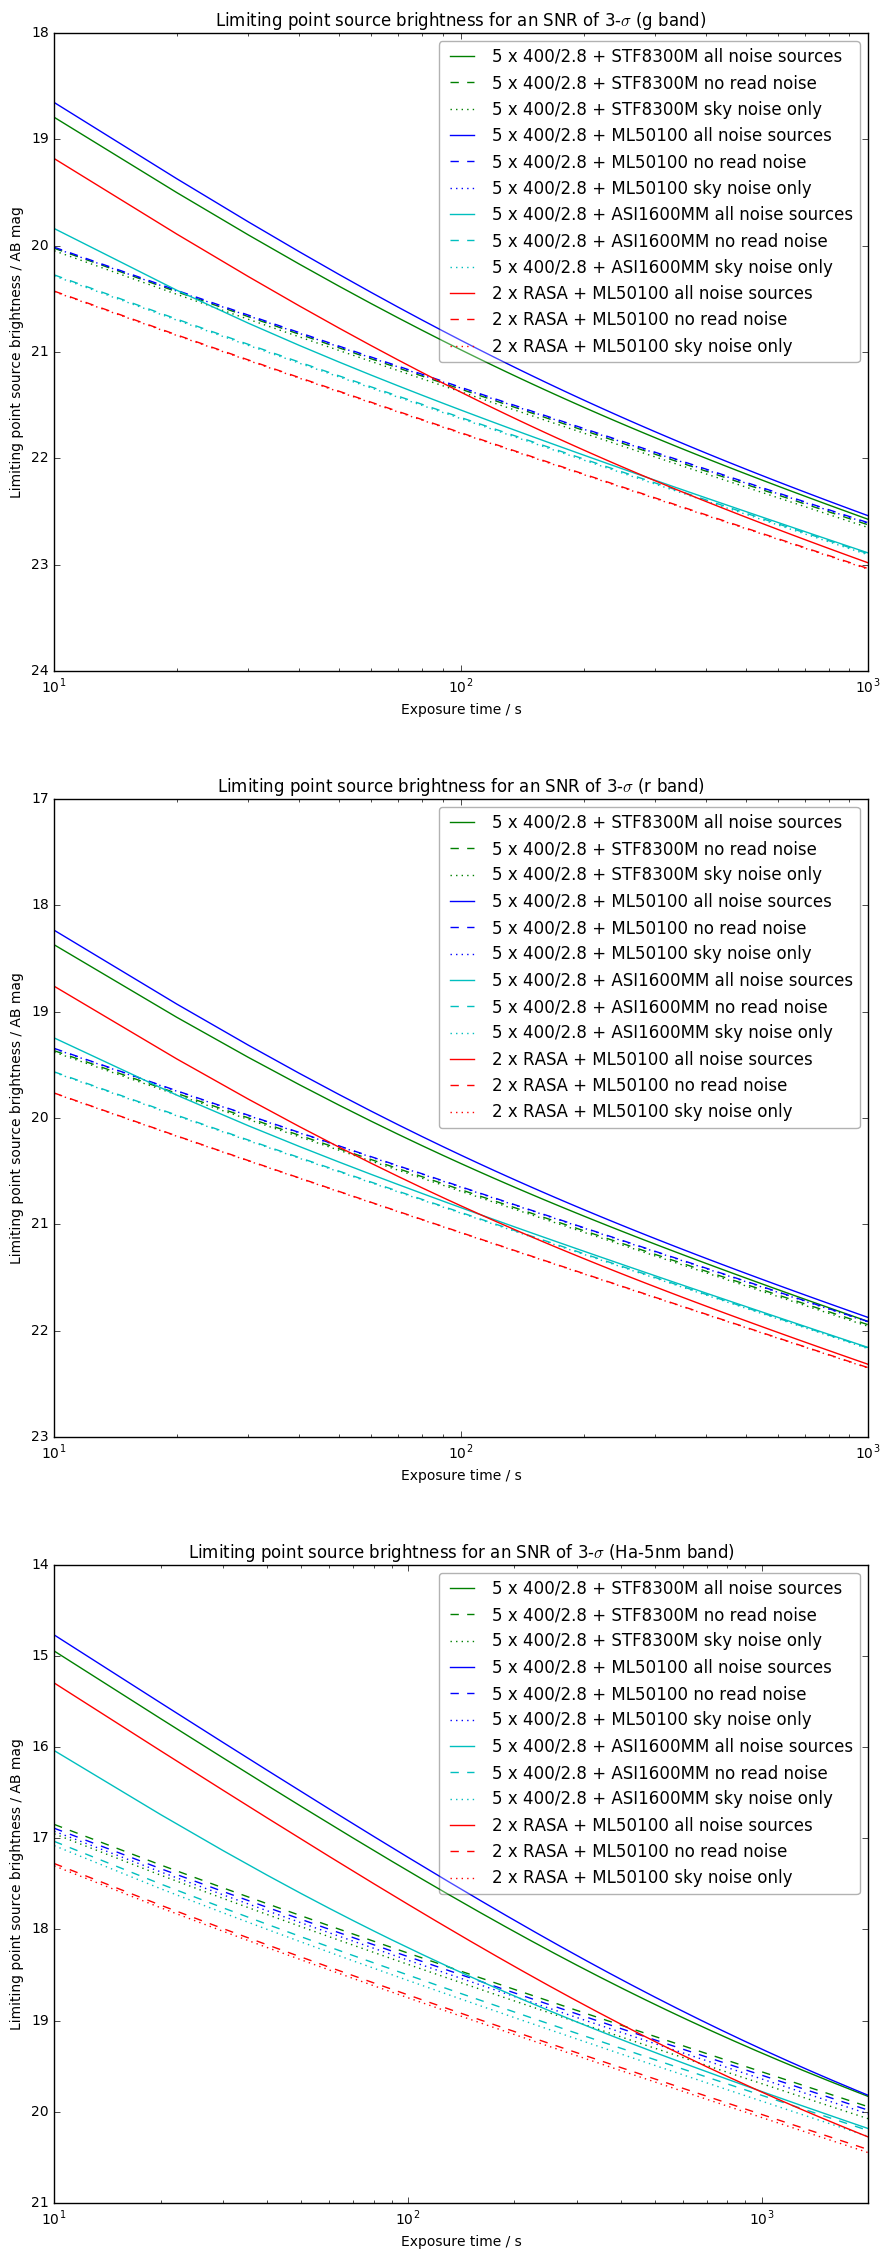

In [52]:
sensitivity_plot(ts, psg, psgr, psgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3) 
sensitivity_plot(ts, psr, psrr, psri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, psh, pshr, pshi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, psg1, psgr1, psgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, psr1, psrr1, psri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, psh1, pshr1, pshi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, psg3, psgr3, psgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, psr3, psrr3, psri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, psh3, pshr3, pshi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, psg2, psgr2, psgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, psr2, psrr2, psri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, psh2, pshr2, pshi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(24,18)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (g band)')
plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(23,17)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(21,14)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot4.png')

The same trend can be spotted in these plots -- 400/2.8 + ASI1600MM being the best option for low exposure times (~10-100 seconds) and RASA + M50100 being the best option for higher exposure times.

Now, we look at plots which use 28 hours as the total exposure times, rather than using a single exposure case. 

In [53]:
#Point source limiting brightness calculations for 28 hour total exposure
ts, qsg, qsgr, qsgi = calculate_limits(canon_sbig_g, 'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
ts, qsr, qsrr, qsri = calculate_limits(canon_sbig_r, 'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
tsh, qsh, qshr, qshi = calculate_limits(canon_sbig_Ha5, 'per pixel', 3.0, 28 * u.hour, ext_exptime, 5, False)
ts, qsg1, qsgr1, qsgi1 = calculate_limits(canon_fli_g,'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
ts, qsr1, qsrr1, qsri1 = calculate_limits(canon_fli_r,'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
tsh, qsh1, qshr1, qshi1 = calculate_limits(canon_fli_Ha5,'per pixel', 3.0, 28 * u.hour, ext_exptime, 5, False)
ts, qsg2, qsgr2, qsgi2 = calculate_limits(rasa_fli_g,'per pixel', 3.0, 28 * u.hour, exptime, 2, False)
ts, qsr2, qsrr2, qsri2 = calculate_limits(rasa_fli_r,'per pixel', 3.0, 28 * u.hour, exptime, 2, False)
tsh, qsh2, qshr2, qshi2 = calculate_limits(rasa_fli_Ha5,'per pixel', 3.0, 28 * u.hour, ext_exptime, 2, False)
ts, qsg3, qsgr3, qsgi3 = calculate_limits(canon_zwo_g, 'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
ts, qsr3, qsrr3, qsri3 = calculate_limits(canon_zwo_r, 'per pixel', 3.0, 28 * u.hour, exptime, 5, False)
tsh, qsh3, qshr3, qshi3 = calculate_limits(canon_zwo_Ha5, 'per pixel', 3.0, 28 * u.hour, ext_exptime, 5, False)

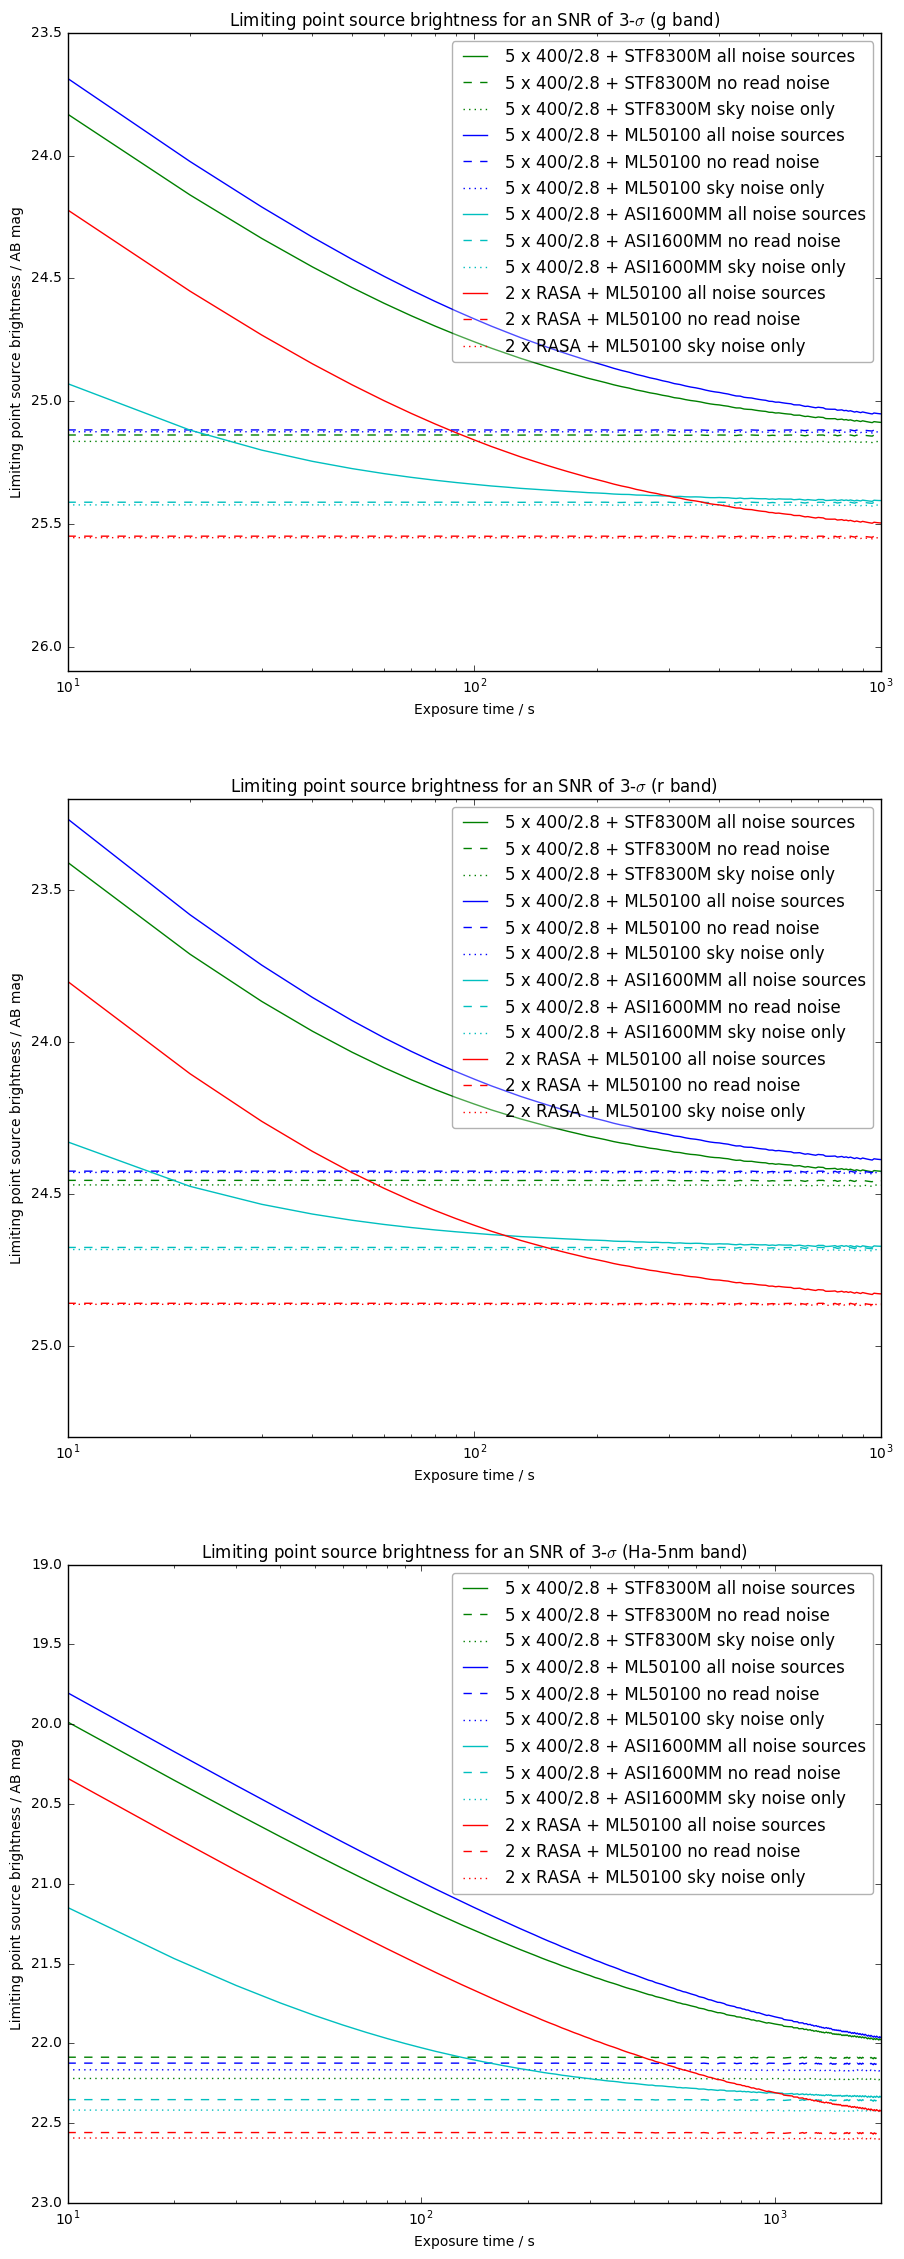

In [54]:
sensitivity_plot(ts, qsg, qsgr, qsgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qsr, qsrr, qsri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, qsh, qshr, qshi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qsg1, qsgr1, qsgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qsr1, qsrr1, qsri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, qsh1, qshr1, qshi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qsg3, qsgr3, qsgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qsr3, qsrr3, qsri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, qsh3, qshr3, qshi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qsg2, qsgr2, qsgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, qsr2, qsrr2, qsri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, qsh2, qshr2, qshi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(26.1,23.5)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (g band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(25.3,23.2)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(23,19)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting point source brightness / AB mag')
plt.title('Limiting point source brightness for an SNR of 3-$\sigma$ (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot5.png')

The trends haven't changed, but one major change is that the limiting point source magnitude values are higher than in the former plots, implying that fainter point objects can be observed. This is obviously due to the 28 hour total exposure time used for these plots.

Now, we calculate the saturation limit of four imager combinations when observing a point source for a single exposure. We plot the saturation limit and the limiting magnitude in the same plot as a function of the exposure time.

In [106]:
def range_plot(data1, imager, bit_depth, full_well, gain, exp_time, plot_number, colour, transparency, name, band):
    if not isinstance(imager, snr.Imager):
        raise ValueError("imager must be an instance of the Imager class")
    data2 = imager.pointsource_saturation(bit_depth, full_well, gain, exp_time)
    plt.subplot(2,1,plot_number)
    plt.semilogx(exp_time, data1, label='{}'.format(name), color=colour)
    plt.semilogx(exp_time, np.where(data1 > data2, data2, data1), color=colour)
    plt.fill_between(exp_time.value, data1.value, np.where(data1.value > data2.value, data2.value, data1.value), facecolor=colour, alpha=transparency)
    plt.title('Point source magnitude range in AB mag for 3-$\sigma$ ({})'.format(band))
    plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
    plt.ylim(22,10)
    plt.xlabel('Exposure time / s')
    plt.ylabel('Point source magnitude / AB mag')
    plt.grid()

In [107]:
#Creating new objects in the camera class for the zwo camera with two extreme read noise values
zwo1 = snr.Camera(pixel_size = 3.8 * u.micron / u.pixel, \
                 resolution = (4656, 3520) * u.pixel, \
                 read_noise = 3.65 * u.electron / u.pixel, \
                 dark_current = darkcur[1] * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ZWO_QE.csv") #the value of the dark current has been approximated
zwo2 = snr.Camera(pixel_size = 3.8 * u.micron / u.pixel, \
                 resolution = (4656, 3520) * u.pixel, \
                 read_noise = 1.3* u.electron / u.pixel, \
                 dark_current = darkcur[1] * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ZWO_QE.csv") #the value of the dark current has been approximated

#Creating new objects in the imager class corresponding to the new objects in the camera class
canon_zwo1_g = snr.Imager(canon, zwo1, g_Astrodon, canon_zwo_psf)
canon_zwo2_g = snr.Imager(canon, zwo2, g_Astrodon, canon_zwo_psf)
canon_zwo1_r = snr.Imager(canon, zwo1, r_Astrodon, canon_zwo_psf)
canon_zwo2_r = snr.Imager(canon, zwo2, r_Astrodon, canon_zwo_psf)

In [108]:
#Since we want to calculate the range, we want to use N=1 for the point source limiting magnitude calculations, so we create new variables
ts, psgt, psgrt, psgit = calculate_limits(canon_sbig_g, 'per pixel', 3.0, exptime, exptime, 1, False)
ts, psrt, psrrt, psrit = calculate_limits(canon_sbig_r, 'per pixel', 3.0, exptime, exptime, 1, False)
ts, psg1t, psgr1t, psgi1t= calculate_limits(canon_fli_g,'per pixel', 3.0, exptime, exptime, 1, False)
ts, psr1t, psrr1t, psri1t = calculate_limits(canon_fli_r,'per pixel', 3.0, exptime, exptime, 1, False)
ts, psg2t, psgr2t, psgi2t = calculate_limits(rasa_fli_g,'per pixel', 3.0, exptime, exptime, 1, False)
ts, psr2t, psrr2t, psri2t = calculate_limits(rasa_fli_r,'per pixel', 3.0, exptime, exptime, 1, False)
ts, psg3t, psgr3t, psgi3t = calculate_limits(canon_zwo1_g, 'per pixel', 3.0, exptime, exptime, 1, False)
ts, psr3t, psrr3t, psri3t = calculate_limits(canon_zwo1_r, 'per pixel', 3.0, exptime, exptime, 1, False)
ts, psg4t, psgr4t, psgi4t = calculate_limits(canon_zwo2_g, 'per pixel', 3.0, exptime, exptime, 1, False)
ts, psr4t, psrr4t, psri4t = calculate_limits(canon_zwo2_r, 'per pixel', 3.0, exptime, exptime, 1, False)

/Users/huntsman/anaconda3/lib/python3.5/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/huntsman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/Users/huntsman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


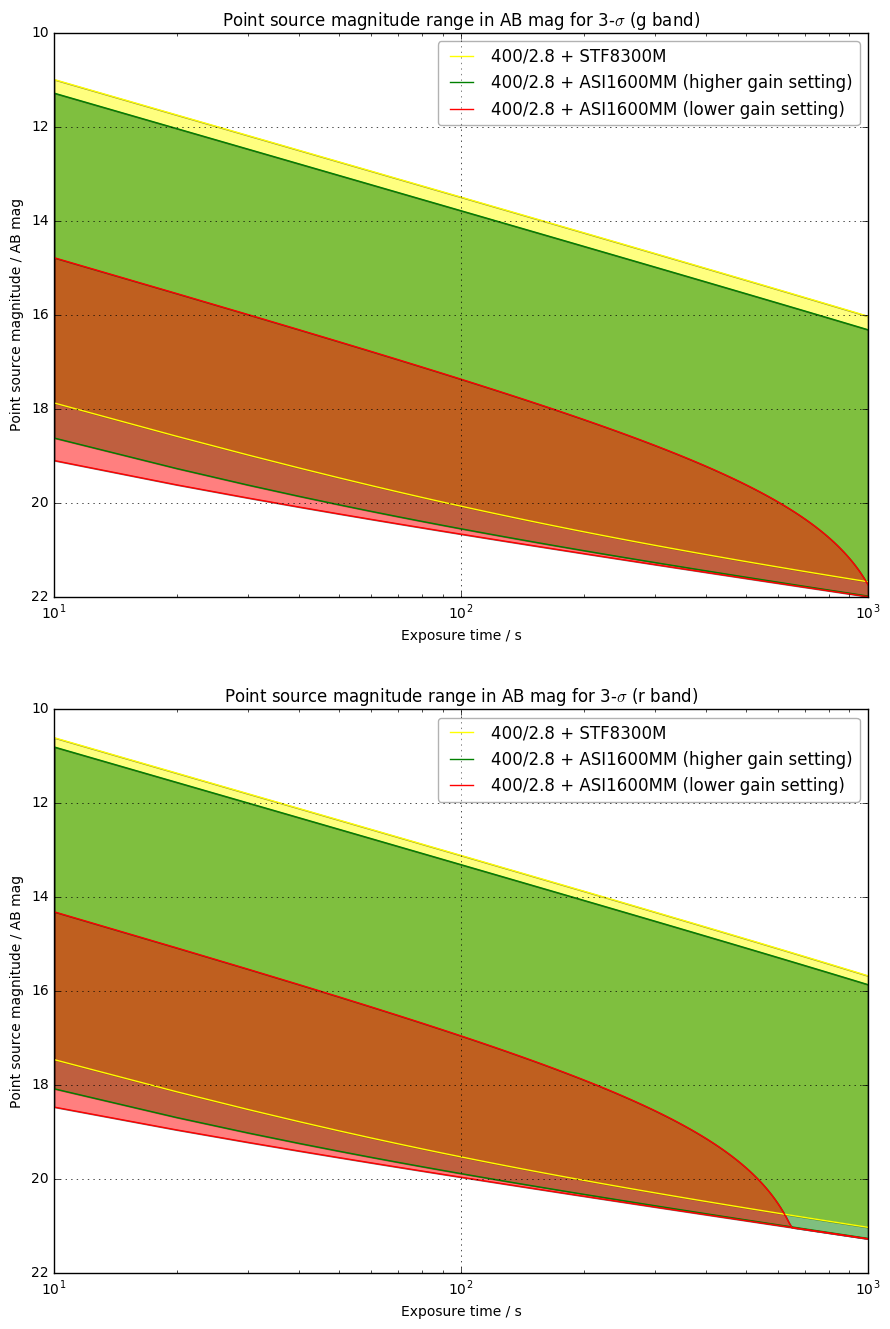

In [109]:
#Plotting the range for the different imager combinations for the g band
range_plot(psgt, canon_sbig_g, 16, 25500 * u.electron, 0.37 * u.electron/u.adu, exptime, 1, 'yellow', 0.5, '400/2.8 + STF8300M', 'g band')
range_plot(psg3t, canon_zwo_g, 12, 20000* u.electron, 5 * u.electron/u.adu, exptime, 1, 'green', 0.5, '400/2.8 + ASI1600MM (higher gain setting)', 'g band')
range_plot(psg4t, canon_zwo_g, 12, 650 * u.electron, 0.20 * u.electron/u.adu, exptime, 1, 'red', 0.5, '400/2.8 + ASI1600MM (lower gain setting)', 'g band')
range_plot(psrt, canon_sbig_r, 16, 25500 * u.electron, 0.37 * u.electron/u.adu, exptime, 2, 'yellow', 0.5, '400/2.8 + STF8300M', 'r band')
range_plot(psr3t, canon_zwo_r, 12, 20000* u.electron, 5 * u.electron/u.adu, exptime, 2, 'green', 0.5, '400/2.8 + ASI1600MM (higher gain setting)', 'r band')
range_plot(psr4t, canon_zwo_r, 12, 650 * u.electron, 0.20 * u.electron/u.adu, exptime, 2, 'red', 0.5, '400/2.8 + ASI1600MM (lower gain setting)', 'r band')
plt.gcf().set_size_inches(10.5,16)
plt.savefig('range_plot.png')

## Tables

Tables corresponding to the above plots have been presented below, for further comparison of the limiting brightness of the different imager combinations at various sub-exposure times. The first three tables show the limiting surface brightness, at various sub-exposure times for g-,r- and Ha-5nm bands respectively.

In [58]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the g band
exp_time=[10, 30, 100, 300, 1000]
canon_sbig_gband=[pg[0].value , pg[2].value, pg[9].value, pg[29].value, pg[-1].value]
canon_fli_gband=[pg1[0].value, pg1[2].value, pg1[9].value, pg1[29].value, pg1[-1].value]
rasa_fli_gband=[pg2[0].value, pg2[2].value, pg2[9].value, pg2[29].value, pg2[-1].value]
canon_zwo_gband=[pg3[0].value, pg3[2].value, pg3[9].value, pg3[29].value, pg3[-1].value]
comparison_table_g = Table([exp_time, canon_sbig_gband, canon_fli_gband, canon_zwo_gband, rasa_fli_gband], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
comparison_table_g['Exposure time'].unit=u.second
comparison_table_g['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_g['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_g['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_g['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_g.write('resources/comparison_table_gband.csv')
comparison_table_g.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,21.9697869801,21.918191651,22.7616401404,22.1391470228
30,23.0785198591,23.0425352843,23.6676579236,23.2502169383
100,24.166341906,24.1623997082,24.5025333225,24.3424765179
300,25.0000408794,25.0285711132,25.1738048965,25.1800423398
1000,25.7740289697,25.8248297925,25.8635151219,25.9560019864


In [59]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the r band
exp_time=[10, 30, 100, 300, 1000]
canon_sbig_rband=[pr[0].value , pr[2].value, pr[9].value, pr[29].value, pr[-1].value]
canon_fli_rband=[pr1[0].value, pr1[2].value, pr1[9].value, pr1[29].value, pr1[-1].value]
rasa_fli_rband=[pr2[0].value, pr2[2].value, pr2[9].value, pr2[29].value, pr2[-1].value]
canon_zwo_rband=[pr3[0].value, pr3[2].value, pr3[9].value, pr3[29].value, pr3[-1].value]
comparison_table_r= Table([exp_time, canon_sbig_rband, canon_fli_rband, canon_zwo_rband, rasa_fli_rband], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
#comparison_table_r.remove_column('idx')
comparison_table_r['Exposure time'].unit=u.second
comparison_table_r['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_r['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_r['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_r['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_r.write('resources/comparison_table_rband.csv')
comparison_table_r.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,21.5502585329,21.5006722157,22.1772372655,21.720724536
30,22.6128194187,22.5844274631,23.0195398502,22.7848528179
100,23.6198185454,23.6258811014,23.8060275171,23.7939545737
300,24.3853346292,24.4177083771,24.4557570701,24.5604682305
1000,25.1176994373,25.1646003863,25.1353229851,25.2927905769


In [60]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the Ha-5nm band
exp_time=[10, 30, 300, 1000, 2000]
canon_sbig_Ha5band=[ph[0].value , ph[2].value, ph[9].value, ph[29].value, ph[-1].value]
canon_fli_Ha5band=[ph1[0].value, ph1[2].value, ph1[9].value, ph1[29].value, ph1[-1].value]
rasa_fli_Ha5band=[ph2[0].value, ph2[2].value, ph2[9].value, ph2[29].value, ph2[-1].value]
canon_zwo_Ha5band=[ph3[0].value, ph3[2].value, ph3[9].value, ph3[29].value, ph3[-1].value]
comparison_table_Ha5 = Table([exp_time, canon_sbig_Ha5band, canon_fli_Ha5band, canon_zwo_Ha5band, rasa_fli_Ha5band], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
#comparison_table_r.remove_column('idx')
comparison_table_Ha5['Exposure time'].unit=u.second
comparison_table_Ha5['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_Ha5['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_Ha5['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_Ha5['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_Ha5.write('resources/comparison_table_Ha-5nmband.csv')
comparison_table_Ha5.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,18.1220634206,18.0336799452,18.9472840225,18.2543397476
30,19.2942602009,19.2125226952,20.0506144504,19.4303849067
300,20.5350998597,20.473575889,21.1304128942,20.6827938042
1000,21.5744429517,21.5531673874,21.9615446051,21.7445574878
2000,23.027906714,23.0988875928,23.1527420176,23.2461498866


In [61]:
2.8/2.2

1.2727272727272725

In [62]:
x=(2.8/2.2)**2
10**(-0.4*x)

0.22493970212948952

In [63]:
lgi2[0]-lgi1[0]

<Quantity 0.8234548310686165 mag(AB)>

In [64]:
lgi1[0]

<Quantity 22.04469181943976 mag(AB)>

In [65]:
canon_sbig_g.pixel_area


<Quantity 8.1149205318895 arcsec2 / pix>

In [66]:
canon_sbig_r.pixel_area


<Quantity 8.1149205318895 arcsec2 / pix>

In [67]:
canon_fli_r.pixel_area

<Quantity 10.018420409740122 arcsec2 / pix>

In [68]:
rasa_fli_r.pixel_area

<Quantity 3.9844592368925063 arcsec2 / pix>

In [69]:
x=np.sqrt(rasa.aperture_area/canon.aperture_area)
y=np.log(x)
z=y/0.4
print(z)

1.4296577286124459


In [70]:
lgi2[0]-lgi1[0]

<Quantity 0.8234548310686165 mag(AB)>

In [71]:
min(1,2)

1

In [77]:
x = np.arange(9.).reshape(3, 3)
print (x)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]


In [79]:
np.where( x > 5 )

(array([2, 2, 2]), array([0, 1, 2]))